In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from scipy import ndimage
from skimage.transform import rescale, resize, downscale_local_mean

In [ ]:
#Steps
'''
1. get images into a matrix
2. handle uniform sizing of images
    Find the sizing of each images. Investigate
3. combine masks
4. combine all into x and y
5. 
'''

In [36]:
image_dim = []

In [74]:
# collect all the image dimentions
# collect all the images
image_dim = []
images = []
train_path = './train/'
for f in os.listdir(train_path):
    fold_path = train_path + f + '/images/'
    im_name = os.listdir(fold_path)
    im_path = fold_path + im_name[0]
    im = plt.imread(im_path)
    im = im[:, :, 0]
    image_dim.append(im.shape)
    images.append(im)

In [51]:
#look at different dimentions for each  iamge
groups = []
counts = np.zeros(9)
for shape in image_dim:
    if shape not in groups:
        groups.append(shape)
    group = groups.index(shape)
    counts[group] += 1
counts = counts.reshape((9,1))
total = np.hstack((groups, counts))

In [68]:
#cols: rows, cols, freq
np.set_printoptions(suppress=True)
total

array([[ 260.,  347.,    5.],
       [ 360.,  360.,   91.],
       [ 256.,  256.,  334.],
       [1024., 1024.,   16.],
       [ 256.,  320.,  112.],
       [ 520.,  696.,   92.],
       [ 603., 1272.,    6.],
       [ 512.,  640.,   13.],
       [1040., 1388.,    1.]])

/home/caleb/miniconda3/envs/databasic/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


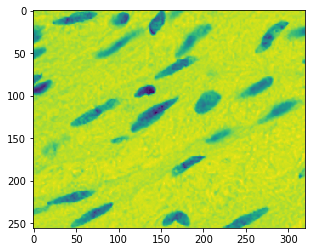

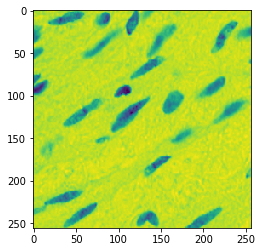

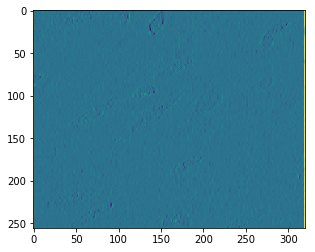

In [100]:
#doing some reshaping and looking at differences
num = 40
original_shape = images[num].shape
aa = resize(images[num], (256, 256))
rev = resize(aa, original_shape)
plt.imshow(images[num])
plt.show()
plt.imshow(aa)
plt.show()
diff = images[num] - rev
plt.imshow(diff)
plt.show()


# building uniform feature set by dividing images into tiles

In [2]:
'''
in: 
1. input_size - the originial dimenstion
2. tile_size  - the dimension in the same direction of the tile

out:
1. overlap    - the overlap between each tile in that dimension
2. num_win    - the number of tiles with overlap needed to span the original dimension

desc:
given the size of one of the dimensions of an image, this method figures out how arrange a number
of evenly sized and overlapping tiles to span that dimension fully and without spilling over.
need to run this method for each dimension of an image to get the tiles overlap in both directions.
'''

#given an iamge shape, and a desired shape, give back a chart of indicies to chop up your original images by 
def get_overlap(input_size, tile_size):
    
    #see how many windows will fit in
    if input_size % tile_size == 0:
        return 0, int(input_size/tile_size)
    else:
        num_win = int(input_size / tile_size)+1
    
        overlap = 0
        while overlap == 0 or overlap % 1 != 0:
            overlap = (tile_size * num_win - input_size)/(num_win - 1)
            num_win += 1
        return overlap, num_win-1

In [3]:
#returns the indicies for each tile for a particular image
#one row in returned list is [row start, row stop, col start, col stop]

'''
in:
1. input shape - the original shape of the image
2. tile shape  - the shape of your tile

out:
a list of length 4 tuples. Each tuple represents the 
indicies for one tile on the original images.
tuples are ordered as follows:
    [row start index, row stop index, col start index, col stop index]
    
desc:
given the shape of your image and tile, returns the indicies of every tile
that should be extracted from the image and its aggregated mask
'''

def get_tile_indicies(input_shape, tile_shape):
    row_ov, num_win_rowwise = get_overlap(input_shape[0], tile_shape[0])
    col_ov, num_win_colwise = get_overlap(input_shape[1], tile_shape[1])
    
    size_row_img = input_shape[0]
    size_col_img = input_shape[1]
    
    size_row_win = tile_shape[0]
    size_col_win = tile_shape[1]
    
    indicies = []
    
    row = 0
    while row+size_row_win <= size_row_img:
        col = 0
        while col+size_col_win <= size_col_img:
            entry = [row, row+size_row_win, col, col+size_col_win]
            entry = [ int(x) for x in entry ]
            indicies.append(entry)
            col = col + size_col_win - col_ov
        row = row + size_row_win - row_ov
    return indicies

In [26]:
'''
given the folder where the masks are located,
aggregates each individual mask and returns 
the final aggragated mask
'''
def get_agg_mask(mask_folder):
    agg_mask = 0 
    i = 0
    for m in os.listdir(mask_folder):
        mask = plt.imread(mask_folder + m)
        if i == 0:
            agg_mask = mask 
        else:
            agg_mask += mask
        i += 1
    return agg_mask

In [5]:
'''
given an image folder, returns one the R element
of the RGB from the iamge because RGB are all the same
'''
def get_image(image_folder):
    im_name = os.listdir(image_folder)
    im_path = image_folder + im_name[0]
    im = plt.imread(im_path)
    im = im[:, :, 0]
    return im

In [39]:
'''
main loop to load raw kaggle data into feature set
dim1, dim2 is the size of the tiles to be extracted from images
dim1 - num rows
dim2 -  num col

'''

#build fs with resized images and aggregated masks
train_path = './train/'
dim1 = 256
dim2 = 256
fs = []

#loop through training examples
for f in os.listdir(train_path):
    
    #get image and aggregated masks
    exp_path = train_path + f
    agg_mask = get_agg_mask(exp_path + '/masks/')
    im = get_image(exp_path + '/images/')
                   
    #get image and mask tile indicies assuming they are the same size
    tiles = get_tile_indicies(im.shape, (dim1, dim2))
    
    #grab each tile from the entire image and add it to the featset
    for ind in tiles:
        im_tile = im[ind[0]:ind[1], ind[2]: ind[3]]
        mask_tile = agg_mask[ind[0]:ind[1], ind[2]: ind[3]]
        entry = [list(im_tile.flatten()), list(mask_tile.flatten())]
        fs.append(entry)

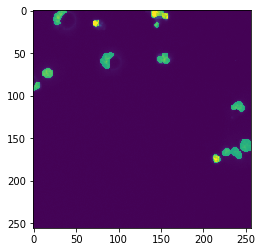

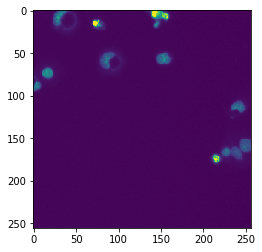

In [38]:
fnum = 11

a = np.array(fs[fnum][0]).reshape(256, 256)
b = np.array(fs[fnum][1]).reshape(256, 256)

combine = a + b
plt.imshow(combine)
plt.show()

plt.imshow(a)
plt.show()